### Follow Gaze Patterns in Children With Autism Spectrum Disorder to Emotional Faces: Scanpath and Similarit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Tạo thư mục để lưu model nếu chưa có
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')
# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid') # Hoặc 'ggplot' nếu seaborn lỗi


In [2]:
# Đọc file dữ liệu
try:
    df = pd.read_csv('original_file.csv')
    print(" Đã đọc file thành công.")
except FileNotFoundError:
    print(" Lỗi: Không tìm thấy file 'original_file.csv'")
    # Dừng execution nếu không có file (trong Jupyter bạn phải tự stop)

# --- TÍNH TOÁN KHOẢNG CÁCH AOI ---
AOI_EYES_X = 512; AOI_EYES_Y = 350
AOI_MOUTH_X = 512; AOI_MOUTH_Y = 550

df['DIST_EYES'] = np.sqrt((df['FIX_X'] - AOI_EYES_X)**2 + (df['FIX_Y'] - AOI_EYES_Y)**2)
df['DIST_MOUTH'] = np.sqrt((df['FIX_X'] - AOI_MOUTH_X)**2 + (df['FIX_Y'] - AOI_MOUTH_Y)**2)

# Hàm Pivot
def pivot_feature(df, value_col):
    df_pivoted = df.pivot_table(
        index=['numeric_id', 'image_id', 'label'],
        columns='FIX_INDEX',
        values=value_col
    ).reset_index()
    
    step_cols = [i for i in range(1, 21)]
    # Lấp đầy NaNs: Ngược trước, Xuôi sau
    df_pivoted[step_cols] = df_pivoted[step_cols].bfill(axis=1).ffill(axis=1)
    return df_pivoted, df_pivoted[step_cols].values

print(" Đang xử lý 4 đặc trưng (Pupil, Duration, Dist_Eyes, Dist_Mouth)...")

# --- PIVOT & BASELINE CORRECTION ---
df_meta, pupil_values = pivot_feature(df, 'FIX_PUPIL')
pupil_baseline = pupil_values[:, 0].reshape(-1, 1)
pupil_values = pupil_values - pupil_baseline 

_, dur_values = pivot_feature(df, 'FIX_DURATION')
_, deye_values = pivot_feature(df, 'DIST_EYES') 
_, dmou_values = pivot_feature(df, 'DIST_MOUTH')

# --- GỘP THÀNH KHỐI 3D ---
X_all = np.stack([pupil_values, dur_values, deye_values, dmou_values], axis=2)
y_all = df_meta['label'].values
ids_all = df_meta['numeric_id'].values

print(f" Kích thước dữ liệu: {X_all.shape}")

 Đã đọc file thành công.
 Đang xử lý 4 đặc trưng (Pupil, Duration, Dist_Eyes, Dist_Mouth)...
 Kích thước dữ liệu: (15912, 20, 4)


In [3]:
# Lấy danh sách bệnh nhân để chia Fold
patients_info = df_meta[['numeric_id', 'label']].drop_duplicates()
unique_patients = patients_info['numeric_id'].values
patient_labels = patients_info['label'].values 

# Thiết lập K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Biến lưu kết quả tổng hợp
fold_histories = []  # Lưu lịch sử loss/acc của từng fold để vẽ
fold_accuracies = []
fold_recalls = []
fold_cms = []        # Lưu confusion matrix từng fold

print("Đã thiết lập K-Fold (5 phần).")

Đã thiết lập K-Fold (5 phần).


In [4]:


print(" BẮT ĐẦU CHẠY 5-FOLD CROSS VALIDATION...")

for fold, (train_idx, val_idx) in enumerate(kfold.split(unique_patients, patient_labels)):
    print(f"\n{'='*20} FOLD {fold+1}/5 {'='*20}")
    
    # --- A. CHIA DỮ LIỆU ---
    fold_train_ids = unique_patients[train_idx]
    fold_val_ids = unique_patients[val_idx]
    
    train_mask = np.isin(ids_all, fold_train_ids)
    val_mask = np.isin(ids_all, fold_val_ids)
    
    X_train_fold = X_all[train_mask]
    y_train_fold = y_all[train_mask]
    X_val_fold = X_all[val_mask]
    y_val_fold = y_all[val_mask]
    ids_val_fold = ids_all[val_mask]
    
    # --- B. CHUẨN HÓA ---
    for i in range(4):
        scaler = RobustScaler()
        X_train_fold[:, :, i] = scaler.fit_transform(X_train_fold[:, :, i])
        X_val_fold[:, :, i] = scaler.transform(X_val_fold[:, :, i])
        
    # --- C. XÂY DỰNG MÔ HÌNH ---
    model = Sequential()
    model.add(Input(shape=(20, 4)))
    
    model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5)) 
    model.add(BatchNormalization())
    
    model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    # Callbacks
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=0)
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    # --- [MỚI] CHECKPOINT ĐỂ LƯU MODEL ---
    model_path = f'saved_models/model_fold_{fold+1}.keras'
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
    
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    # --- D. HUẤN LUYỆN ---
    print(f"Đang huấn luyện Fold {fold+1}...")
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=50,  # Đặt 80 cho chắc chắn
        batch_size=256, # 64 thường ổn định hơn 256 cho LSTM
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stop, lr_scheduler, checkpoint], # Thêm checkpoint vào đây
        verbose=1 
    )
    fold_histories.append(history)
    
    # --- E. ĐÁNH GIÁ ---
    # Tải lại model tốt nhất đã lưu để đánh giá (Best Weights)
    best_model = tf.keras.models.load_model(model_path)
    y_pred_prob = best_model.predict(X_val_fold, verbose=0)
    
    results = pd.DataFrame({
        'numeric_id': ids_val_fold,
        'true_label': y_val_fold,
        'prob_score': y_pred_prob.flatten()
    })
    
    # Aggregation
    final_results = results.groupby('numeric_id').agg(
        final_prob=('prob_score', 'mean'),
        true_label=('true_label', 'first')
    ).reset_index()
    
    final_results['final_pred'] = (final_results['final_prob'] > 0.5).astype(int)
    
    acc = accuracy_score(final_results['true_label'], final_results['final_pred'])
    report = classification_report(final_results['true_label'], final_results['final_pred'], output_dict=True)
    recall_asd = report['1']['recall'] if '1' in report else 0.0
    cm = confusion_matrix(final_results['true_label'], final_results['final_pred'])
    
    fold_accuracies.append(acc)
    fold_recalls.append(recall_asd)
    fold_cms.append(cm)
    
    print(f"Hoàn thành Fold {fold+1}")
    print(f"   -> Accuracy: {acc*100:.2f}% | ASD Recall: {recall_asd*100:.2f}%")
    print(f"   -> Đã lưu model tại: {model_path}")

print("\nĐÃ CHẠY XONG VÀ LƯU 5 MODELS!")

 BẮT ĐẦU CHẠY 5-FOLD CROSS VALIDATION...

==================== FOLD 1/5 ====================
Đang huấn luyện Fold 1...
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.6259 - loss: 2.8879 - val_accuracy: 0.6646 - val_loss: 2.5990 - learning_rate: 5.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.6607 - loss: 2.3575 - val_accuracy: 0.6599 - val_loss: 2.1545 - learning_rate: 5.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6707 - loss: 1.9571 - val_accuracy: 0.6630 - val_loss: 1.8050 - learning_rate: 5.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6692 - loss: 1.6548 - val_accuracy: 0.6680 - val_loss: 1.5393 - learning_rate: 5.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.6807 - loss: 1.4183 - val_accuracy: 0.6743 - val_loss: 1.3393 - learning_rate: 5.0000e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6834 - loss: 1.2494 - val_accuracy: 0.681

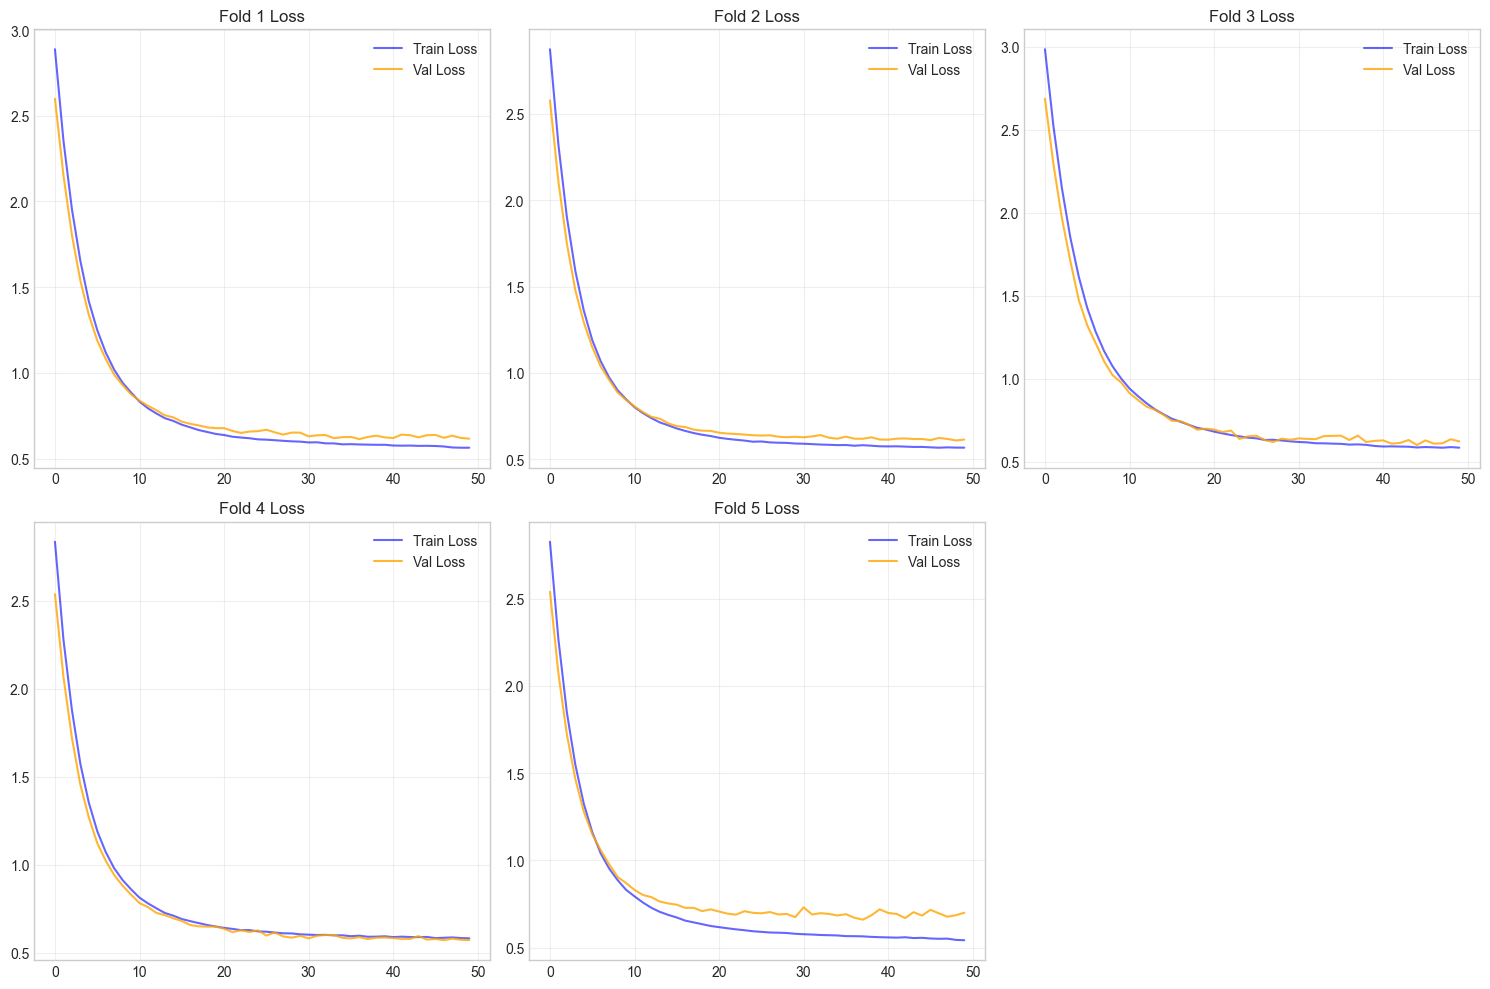

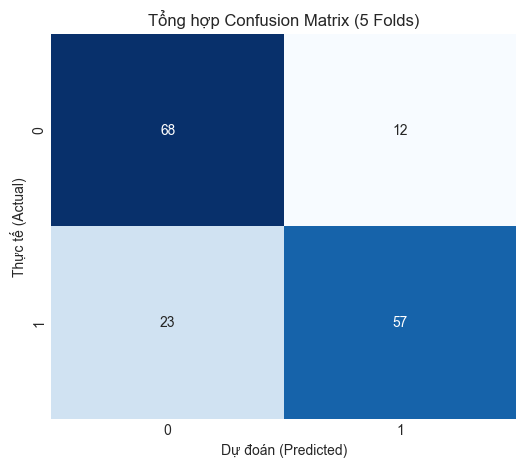


BẢNG TỔNG KẾT CHI TIẾT:
            Fold  Accuracy  ASD Recall
0         Fold 1   0.68750      0.6875
1         Fold 2   0.78125      0.6875
2         Fold 3   0.81250      0.6250
3         Fold 4   0.87500      0.8750
4         Fold 5   0.75000      0.6875
Mean  Trung bình   0.78125      0.7125


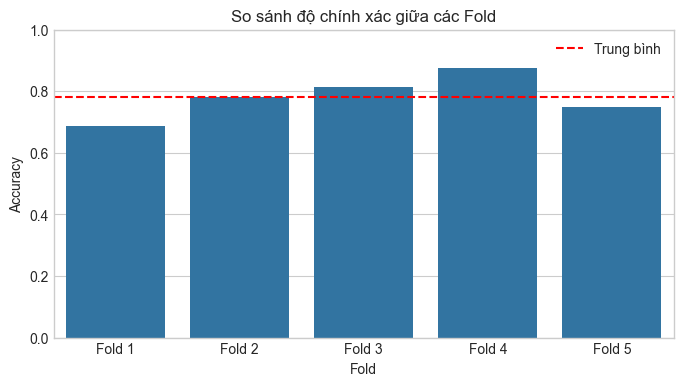

In [5]:
# --- 1. BIỂU ĐỒ LOSS & ACCURACY CỦA TỪNG FOLD ---
plt.figure(figsize=(15, 10))

for i, history in enumerate(fold_histories):
    # Vẽ Loss
    plt.subplot(2, 3, i+1) # Sắp xếp lưới 2x3 (cho 5 hình)
    plt.plot(history.history['loss'], label='Train Loss', color='blue', alpha=0.6)
    plt.plot(history.history['val_loss'], label='Val Loss', color='orange', alpha=0.8)
    plt.title(f'Fold {i+1} Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Vẽ Accuracy trung bình (Optional) - Có thể vẽ riêng
plt.tight_layout()
plt.show()

# --- 2. BIỂU ĐỒ CONFUSION MATRIX TỔNG HỢP ---
# Cộng dồn ma trận nhầm lẫn của 5 folds
total_cm = np.sum(fold_cms, axis=0)

plt.figure(figsize=(6, 5))
sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Tổng hợp Confusion Matrix (5 Folds)')
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.show()

# --- 3. BẢNG TỔNG KẾT CHỈ SỐ ---
summary_df = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(5)],
    'Accuracy': fold_accuracies,
    'ASD Recall': fold_recalls
})
# Thêm dòng trung bình
summary_df.loc['Mean'] = ['Trung bình', np.mean(fold_accuracies), np.mean(fold_recalls)]

print("\nBẢNG TỔNG KẾT CHI TIẾT:")
print(summary_df)

# Vẽ biểu đồ cột so sánh Accuracy các fold
plt.figure(figsize=(8, 4))
sns.barplot(x='Fold', y='Accuracy', data=summary_df.iloc[:-1]) # Bỏ dòng Mean để vẽ
plt.axhline(np.mean(fold_accuracies), color='red', linestyle='--', label='Trung bình')
plt.title('So sánh độ chính xác giữa các Fold')
plt.ylim(0, 1.0)
plt.legend()
plt.show()